<a href="https://colab.research.google.com/github/DommiiUdomp/Well/blob/main/Hungary_LandSurfaceTemperature.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install geopandas contextily geoplot tqdm osmnx geemap

In [ ]:
!pip install -U matplotlib

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import geopandas as gpd

import contextily as cx
import geoplot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from IPython.display import Image
from shapely.geometry import Point, LineString, Polygon, MultiPoint, MultiLineString, MultiPolygon, box
%matplotlib inline

import rasterio
from rasterio.plot import show as rioshow
from shapely.geometry import box
from rasterio.plot import show_hist

import folium
import json, geemap, ee

import networkx as nx
import osmnx as ox
ox.config(use_cache=True, log_console=True)
ox.__version__

'1.1.2'

In [ ]:
!wget 'https://biogeo.ucdavis.edu/data/diva/adm/HUN_adm.zip'

In [ ]:
!unzip '/content/HUN_adm.zip'

In [2]:
HUN_adm0 = gpd.read_file('/content/HUN_adm0.shp')
HUN_adm1 = gpd.read_file('/content/HUN_adm1.shp')
HUN_adm2 = gpd.read_file('/content/HUN_adm2.shp')

HUN_adm2.head()

,ID_0,ISO,NAME_0,ID_1,NAME_1,ID_2,NAME_2,TYPE_2,ENGTYPE_2,NL_NAME_2,VARNAME_2,geometry
0,103,HUN,Hungary,1,Bács-Kiskun,1,Bácsalmás,Kistérség,Subregion,None,Bácsalmási,"POLYGON ((19.51616 46.15385, 19.51568 46.15403..."
1,103,HUN,Hungary,1,Bács-Kiskun,2,Baja,Kistérség,Subregion,None,Bajai,"POLYGON ((19.11987 46.03626, 19.11740 46.03677..."
2,103,HUN,Hungary,1,Bács-Kiskun,3,Jánoshalm,Kistérség,Subregion,None,Jánoshalmi,"POLYGON ((19.29114 46.39982, 19.29857 46.39548..."
3,103,HUN,Hungary,1,Bács-Kiskun,4,Kalocsa,Kistérség,Subregion,None,Kalocsai,"POLYGON ((19.16065 46.31601, 19.15828 46.31803..."
4,103,HUN,Hungary,1,Bács-Kiskun,5,Kecskemét,Kistérség,Subregion,None,Kecskeméti,"POLYGON ((20.12815 46.95933, 20.12278 46.95924..."


<AxesSubplot:>

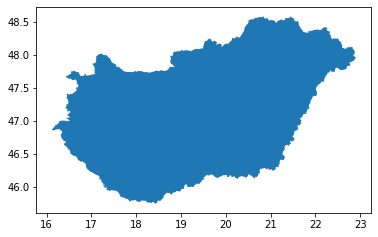

In [3]:
HUN_adm0.plot()

In [14]:
HUN_adm0.centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """Entry point for launching an IPython kernel.


0    POINT (19.41404 47.16732)
dtype: geometry

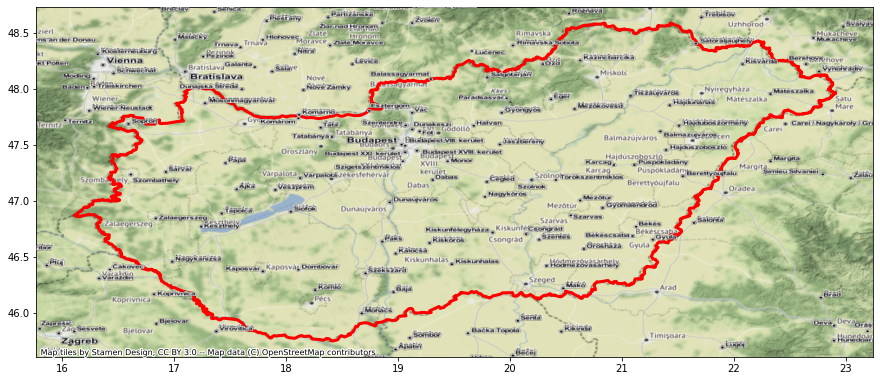

In [175]:
ax = HUN_adm0.plot(figsize=(15,20), color="none", edgecolor="r", linewidth=3)
cx.add_basemap(ax, crs=HUN_adm1.crs.to_string(), source=cx.providers.Stamen.Terrain)
cx.add_basemap(ax, crs=HUN_adm1.crs.to_string(), source=cx.providers.Stamen.TonerLabels)

In [ ]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

In [ ]:
x_map=HUN_adm0.centroid.centroid.x.mean()
y_map=HUN_adm0.centroid.centroid.y.mean()
print(x_map,y_map)

In [5]:
#test API # Print the elevation of Mount Everest.
elv = ee.Image('USGS/SRTMGL1_003')
hu_cenpoi = ee.Geometry.Point([x_map,y_map])
elev = elv.sample(hu_cenpoi, 30).first().get('elevation').getInfo()
print('Entral HU elevation (m):', elev)

# Get a feature collection of administrative boundaries.
countries = ee.FeatureCollection('FAO/GAUL/2015/level0').select('ADM0_NAME')

# Filter the feature collection to subset Hungary.
hungary = countries.filter(ee.Filter.eq('ADM0_NAME', 'Hungary'))

# Make pixels with elevation below sea level transparent.
elv_img = elv.updateMask(elv.gt(0))

# Clip the image by Hungary.
elv_hu = elv_img.clip(hungary)

# Create the URL associated with the styled image data.
url_elv = elv_hu.getThumbUrl({ 'min': 0, 'max': 1000, 'region': hu_cenpoi.buffer(250000), 'dimensions': 1000,
                              'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})

# Display a thumbnail of elevation in Hungary.
Image(url=url_elv)

Entral HU elevation (m): 119


<AxesSubplot:title={'center':'Magyarország'}, xlabel='X', ylabel='Y'>

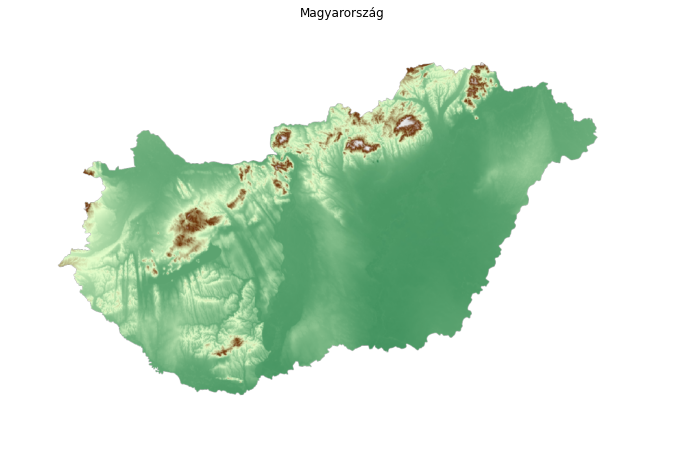

In [32]:
src = elv_hu.getMapId({ 'min': 0, 'max': 1000,
                       'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5']})["tile_fetcher"].url_format
hu_cx = cx.Place("Hungary", source=src)
hu_cx.plot()

In [6]:
def add_ee_layer(self, ee_image_object, vis_params, name):
    """Adds a method for displaying Earth Engine image tiles to folium map."""
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True
    ).add_to(self)

# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [17]:
# Import the MODIS land surface temperature collection.
lst = ee.ImageCollection("MODIS/006/MOD11A1")
lst = lst.select('LST_Day_1km','QC_Day')
lst_date_filter = ee.Filter.date('2021-01-01', '2022-01-01')
lst_dataset = lst.filter(lst_date_filter)

lst_image = lst_dataset.mean()

lst_image = lst_image.select('LST_Day_1km').multiply(0.02)

# Convert Kelvin to Celsius.
lst_image = lst_image.select('LST_Day_1km').add(-273.15)

# Create a map.
Map = folium.Map(location=[y_map,x_map], zoom_start=7, tiles ='Stamen Terrain')

lst_vis_params = { 'min': 10, 'max': 30, 'dimensions': 512, 'region': hu_cenpoi.buffer(500000),
                  'palette': ['blue', 'yellow', 'orange', 'red']}
# Add the layers to the map object.
Map.add_ee_layer(lst_image, lst_vis_params, 'Land Surface Temperature')
# Add a layer control panel to the map.
Map.add_child(folium.LayerControl())

# Display the map.
display(Map)

In [7]:
# define a helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

# create the ee object
hu = ee.Geometry.MultiPolygon(shp_to_ee_fmt(HUN_adm0))

hu_ele = elv_img.clip(hu)

In [14]:
lst_hu = lst_image.clip(hu)

huMap = geemap.Map()
huMap.add_basemap("SATELLITE")
huMap.centerObject(hu, zoom=7)
huMap.addLayer(lst_hu, lst_vis_params, 'Hungary', opacity=.75, )
#huMap.addLayerControl()
huMap.setControlVisibility(layerControl=True, fullscreenControl=True)
huMap

Map(center=[47.17041323737935, 19.397377312490196], controls=(WidgetControl(options=['position', 'transparent_…

In [18]:
task_lst = ee.batch.Export.image.toDrive(image=lst_hu,
                                         description='LandTemp_near_budapest_Hungary',
                                         scale=30,
                                         region=hu,
                                         folder='tmp', fileNamePrefix='lst_hu', crs='EPSG:23700', fileFormat='GeoTIFF', maxPixels=1e9)
task_lst.start()

In [20]:
scale = 1000  # scale in meters
# Calculate and print the mean value of the LST collection at the point.
lst_point = lst.mean().sample(hu_cenpoi, scale).first().get('LST_Day_1km').getInfo()
print('Average daytime LST at urban point:', round(lst_point*0.02 -273.15, 2), '°C')

Average daytime LST at urban point: 22.47 °C


In [148]:
HUN_adm0.bounds.max()

minx    16.111050
miny    45.747829
maxx    22.905584
maxy    48.586376
dtype: float64

In [39]:
HUN_adm0.total_bounds

array([16.11104965, 45.74782944, 22.90558434, 48.58637619])

In [151]:
# find the bounds of your geodataframe
x_min, y_min, x_max, y_max = HUN_adm0.total_bounds

# set sample size
n = 5
# generate random data within the bounds
x = np.random.uniform(x_min, x_max, n)
y = np.random.uniform(y_min, y_max, n)

# convert them to a points GeoSeries
gdf_points = gpd.GeoSeries(gpd.points_from_xy(x, y))
# only keep those points within polygons
gdf_points = gdf_points[gdf_points.within(HUN_adm0.unary_union)]

In [61]:
#gdf_points = gdf_points.to_crs({'init': 'epsg:4326'})
#gdf_points = gdf_points.to_crs(HUN_adm1.crs)

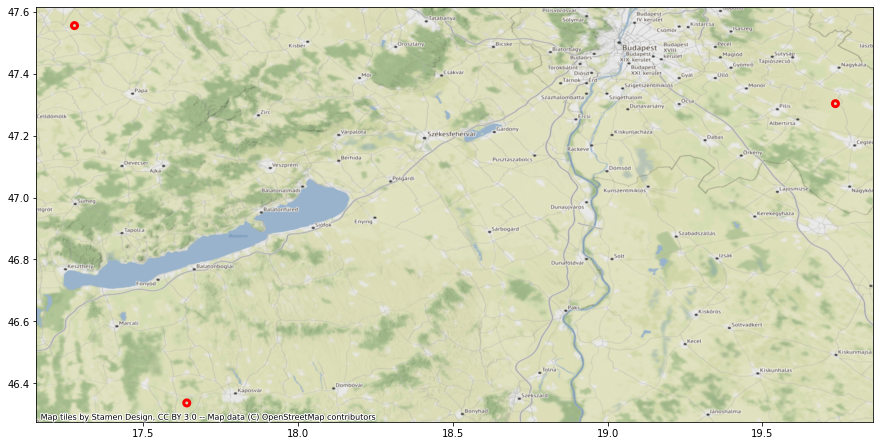

In [152]:
gdf_points.crs = 'epsg:4326'
gdf_points = gdf_points.to_crs(epsg='4326')
ax = gdf_points.plot(figsize=(15,15), color="none", edgecolor="r", linewidth=3)
cx.add_basemap(ax, crs=gdf_points.crs.to_string(), source=cx.providers.Stamen.Terrain)

In [163]:
gdf_points

0    POINT (17.64041 46.33649)
2    POINT (17.27769 47.55567)
4    POINT (19.73617 47.30349)
dtype: geometry

In [153]:
scale = 1000  # scale in meters

lst_poi = lst.getRegion(ee.Geometry.Point(x[0], y[0]), scale).getInfo()
lst_poi = pd.DataFrame(lst_poi)
lst_poi.head(2)

,0,1,2,3,4,5
0,id,longitude,latitude,time,LST_Day_1km,QC_Day
1,2000_02_24,17.638421,46.339594,951350400000,None,2


In [154]:
def ee_array_to_df(x,y):
    """Transforms client-side ee.Image.getRegion array to pandas.DataFrame."""
    scale = 1000  # scale in meters
    df = lst.getRegion(ee.Geometry.Point(x,y), scale).getInfo()
    df = pd.DataFrame(df)

    # Rearrange the header.
    headers = df.iloc[0]
    df = pd.DataFrame(df.values[1:], columns=headers)

    # Remove rows without data inside.
    df = df[['longitude', 'latitude', 'time', 'LST_Day_1km']].dropna()

    # Convert the data to numeric values.
    df['LST_Day_1km'] = pd.to_numeric(df['LST_Day_1km'], errors='coerce')

    # Convert the time field into a datetime.
    df['datetime'] = pd.to_datetime(df['time'], unit='ms')

    # Keep the columns of interest.
    df = df[['time','datetime', 'LST_Day_1km']]

    # Apply the function to get temperature in celsius.
    df['T_CelSius'] =  df['LST_Day_1km']*0.02 - 273.15
    
    return df

In [164]:
lst_df_point0 = ee_array_to_df(x[0], y[0])
lst_df_point2 = ee_array_to_df(x[2], y[2])
lst_df_point4 = ee_array_to_df(x[4], y[4])

In [165]:
lst_df_point4.head(2)

,time,datetime,LST_Day_1km,T_CelSius
2,951523200000,2000-02-26,14124,9.33
3,951609600000,2000-02-27,14346,13.77


In [169]:
# Fitting curves.
## First, extract x values (times) from the dfs.
x_data_0 = np.asanyarray(lst_df_point0['time'].apply(float))  
x_data_2 = np.asanyarray(lst_df_point2['time'].apply(float))  
x_data_4 = np.asanyarray(lst_df_point4['time'].apply(float))  

## Secondly, extract y values (LST) from the dfs.
y_data_0 = np.asanyarray(lst_df_point0['T_CelSius'].apply(float)) 
y_data_2 = np.asanyarray(lst_df_point2['T_CelSius'].apply(float)) 
y_data_4 = np.asanyarray(lst_df_point4['T_CelSius'].apply(float)) 

In [118]:
from scipy import optimize

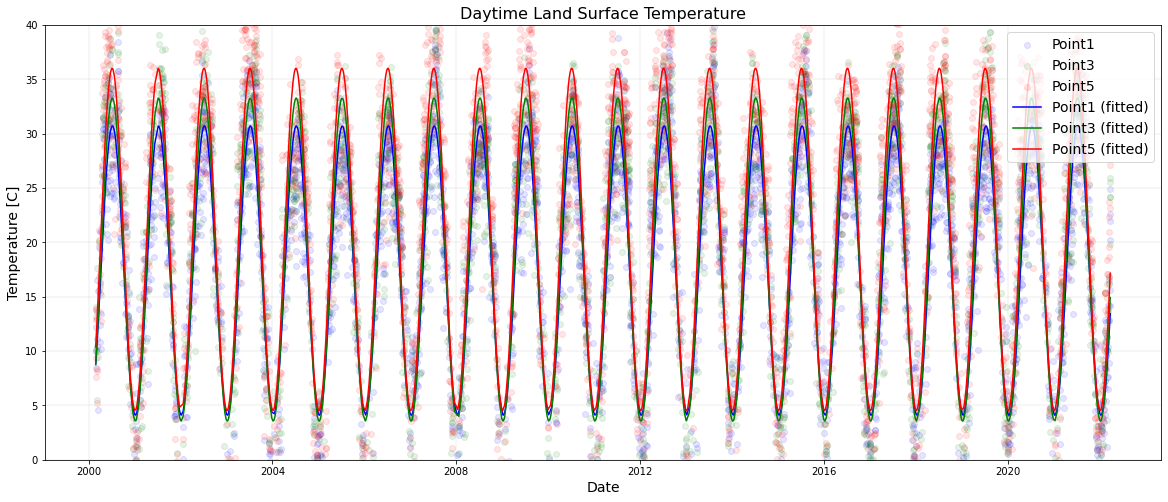

In [174]:
## Then, define the fitting function with parameters.
def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

## Optimize the parameters using a good start p0.
lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000   # milliseconds in a year
phi = 2*np.pi*4*30.5*3600*1000/tau  # offset regarding when we expect LST(t)=LST0

params_0, params_covariance_0 = optimize.curve_fit(fit_func, x_data_0, y_data_0, p0=[lst0, delta_lst, tau, phi])
params_2, params_covariance_2 = optimize.curve_fit(fit_func, x_data_2, y_data_2, p0=[lst0, delta_lst, tau, phi])
params_4, params_covariance_4 = optimize.curve_fit(fit_func, x_data_4, y_data_4, p0=[lst0, delta_lst, tau, phi])

# Subplots.
fig, ax = plt.subplots(figsize=(20, 8))

# Add scatter plots.
ax.scatter(lst_df_point0['datetime'], lst_df_point0['T_CelSius'], c='blue', alpha=0.1, label='Point1')
ax.scatter(lst_df_point2['datetime'], lst_df_point2['T_CelSius'], c='green', alpha=0.1, label='Point3')
ax.scatter(lst_df_point4['datetime'], lst_df_point4['T_CelSius'], c='red', alpha=0.1, label='Point5')
# Add fitting curves.
ax.plot(lst_df_point0['datetime'], 
        fit_func(x_data_0, params_0[0], params_0[1], params_0[2], params_0[3]), label='Point1 (fitted)', color='blue', lw=1.5)
ax.plot(lst_df_point2['datetime'],
        fit_func(x_data_2, params_2[0], params_2[1], params_2[2], params_2[3]), label='Point3 (fitted)', color='green', lw=1.5)
ax.plot(lst_df_point4['datetime'],
        fit_func(x_data_4, params_4[0], params_4[1], params_4[2], params_4[3]), label='Point5 (fitted)', color='red', lw=1.5)

# Add some parameters.
ax.set_title('Daytime Land Surface Temperature', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 40)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='upper right')

plt.show()